In [1]:
import pandas as pd

CAMINHO = "../data/Customers_clustered.csv"

df_clustered = pd.read_csv(CAMINHO)

df_clustered

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,Age,AgeGroup,MntTotal,MntRegularProds,Children,HasChildren,AcceptedCmpTotal,HasAcceptedCmp,TotalNumPurchases,cluster
0,Graduation,Single,58138.0,0,0,58,635,88,546,172,...,57,46-60,1617,1529,0,0,0,0,22,0
1,Graduation,Single,46344.0,1,1,38,11,1,6,2,...,60,46-60,27,21,2,1,0,0,4,1
2,Graduation,Partner,71613.0,0,0,26,426,49,127,111,...,49,46-60,776,734,0,0,0,0,20,0
3,Graduation,Partner,26646.0,1,0,26,11,4,20,10,...,30,18-30,53,48,1,1,0,0,6,1
4,PhD,Partner,58293.0,1,0,94,173,43,118,46,...,33,31-45,422,407,1,1,0,0,14,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,Graduation,Partner,61223.0,0,1,46,709,43,182,42,...,47,46-60,1341,1094,1,1,0,0,16,0
2236,PhD,Partner,64014.0,2,1,56,406,0,30,0,...,68,61+,444,436,3,1,1,1,15,2
2237,Graduation,Single,56981.0,0,0,91,908,48,217,32,...,33,31-45,1241,1217,0,0,1,1,18,0
2238,Master,Partner,69245.0,0,1,8,428,30,214,80,...,58,46-60,843,782,1,1,0,0,21,0


In [2]:
df_clustered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 36 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Education            2240 non-null   object 
 1   Marital_Status       2240 non-null   object 
 2   Income               2240 non-null   float64
 3   Kidhome              2240 non-null   int64  
 4   Teenhome             2240 non-null   int64  
 5   Recency              2240 non-null   int64  
 6   MntWines             2240 non-null   int64  
 7   MntFruits            2240 non-null   int64  
 8   MntMeatProducts      2240 non-null   int64  
 9   MntFishProducts      2240 non-null   int64  
 10  MntSweetProducts     2240 non-null   int64  
 11  MntGoldProds         2240 non-null   int64  
 12  NumDealsPurchases    2240 non-null   int64  
 13  NumWebPurchases      2240 non-null   int64  
 14  NumCatalogPurchases  2240 non-null   int64  
 15  NumStorePurchases    2240 non-null   i

In [3]:
# separar em X e y
X = df_clustered.drop("Response", axis=1)
y = df_clustered.Response

In [4]:
# colunas que passaram por one hot encoding

# vars categóricas (discretas)
one_hot_cols = [
    "Education",
    "Marital_Status",
    "AgeGroup",
    "HasChildren",
    "HasAcceptedCmp",
    "AcceptedCmp1",
    "AcceptedCmp2",
    "AcceptedCmp3",
    "AcceptedCmp4",
    "AcceptedCmp5",
    "Complain",
    "Kidhome",
    "Teenhome",
    "YearsSinceEnrolled",
    "Children",
    "AcceptedCmpTotal",
    "cluster"
]

# vars de distribuicao semelhante à gaussiana
standard_cols = [
    "Income",
    "Age"
]

# vars de distribuicao semelhante à exponenciais
power_cols = X.columns[(X.columns.str.startswith("Mnt")) | (X.columns.str.startswith("Num"))].tolist()

# vars uniformes passarão pela normalização minmax
minmax_cols = [col for col in X.columns if col not in onehot_cols + standard_cols + power_cols]

In [16]:
# selecionando modelos para teste
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline # feita para lidar com dados desbalanceados
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_validate

RANDOM_STATE = 42

models = {
    "DummyClassifier": DummyClassifier(strategy="stratified", random_state=RANDOM_STATE),
    "LogisticRegression": LogisticRegression(random_state=RANDOM_STATE),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "KNNClassifier": KNeighborsClassifier(n_neighbors=5),
}

# aplicar ideia de validação cruzada
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# definir pipeline
def pipeline_model(X, y, model, kf):

    # definir preprocessamento
    preprocessing = ColumnTransformer(
    [
        ("onehot", OneHotEncoder(), onehot_cols),
        ("standar", StandardScaler(), standard_cols),
        ("power", PowerTransformer(), power_cols),
        ("minmax", MinMaxScaler(), minmax_cols)
    ]
    )

    # definir pipeline em si
    pipeline = Pipeline(
        [
            ("preprocessing", preprocessing),
            ("feature_selection", SelectKBest(score_func=f_classif, k=10)),
            ("rus", RandomUnderSampler(random_state=RANDOM_STATE)),
            ("model", model)
        ]
    )

    # definir avaliação
    scores = cross_validate(
        pipeline,
        X, 
        y,
        cv=kf,
        scoring=["accuracy", "precision", "recall", "roc_auc", "average_precision"],
        n_jobs=-2,
        error_score="raise"
    )

    return scores

In [19]:
results = {
    "DummyClassifier": pipeline_model(X, y, models["DummyClassifier"], skf),
    "LogisticRegression": pipeline_model(X, y, models["LogisticRegression"], skf),
    "DecisionTreeClassifier": pipeline_model(X, y, models["DecisionTreeClassifier"], skf),
    "KNNClassifier": pipeline_model(X, y, models["KNNClassifier"], skf),
}

In [20]:
from pprint import pprint


pprint(results)

{'DecisionTreeClassifier': {'fit_time': array([0.31819153, 0.33432317, 0.33133101, 0.32900691, 0.31230927]),
                            'score_time': array([0.14615583, 0.13897491, 0.13598442, 0.12447762, 0.14669871]),
                            'test_accuracy': array([0.65848214, 0.66294643, 0.67857143, 0.67410714, 0.69419643]),
                            'test_average_precision': array([0.19282019, 0.20263267, 0.21919407, 0.22794667, 0.25129932]),
                            'test_precision': array([0.2278481 , 0.24074074, 0.25786164, 0.26627219, 0.28742515]),
                            'test_recall': array([0.53731343, 0.58208955, 0.6119403 , 0.67164179, 0.72727273]),
                            'test_roc_auc': array([0.61241039, 0.62798214, 0.65988953, 0.67266032, 0.71166508])},
 'DummyClassifier': {'fit_time': array([0.16386056, 0.1650238 , 0.1650238 , 0.1650238 , 0.1650238 ]),
                     'score_time': array([0.05965352, 0.04967141, 0.0520463 , 0.07155681, 0.04633617

In [23]:
for k in results.keys():
    results[k]["time"] = results[k]["fit_time"] + results[k]["score_time"]

In [24]:
pprint(results)

{'DecisionTreeClassifier': {'fit_time': array([0.31819153, 0.33432317, 0.33133101, 0.32900691, 0.31230927]),
                            'score_time': array([0.14615583, 0.13897491, 0.13598442, 0.12447762, 0.14669871]),
                            'test_accuracy': array([0.65848214, 0.66294643, 0.67857143, 0.67410714, 0.69419643]),
                            'test_average_precision': array([0.19282019, 0.20263267, 0.21919407, 0.22794667, 0.25129932]),
                            'test_precision': array([0.2278481 , 0.24074074, 0.25786164, 0.26627219, 0.28742515]),
                            'test_recall': array([0.53731343, 0.58208955, 0.6119403 , 0.67164179, 0.72727273]),
                            'test_roc_auc': array([0.61241039, 0.62798214, 0.65988953, 0.67266032, 0.71166508]),
                            'time': array([0.46434736, 0.47329807, 0.46731544, 0.45348454, 0.45900798])},
 'DummyClassifier': {'fit_time': array([0.16386056, 0.1650238 , 0.1650238 , 0.1650238 , 0.1650238

In [32]:
df_results = pd.DataFrame(results).T.reset_index().rename(columns={"index":"model"})

df_results

,model,fit_time,score_time,test_accuracy,test_precision,test_recall,test_roc_auc,test_average_precision,time
0,DummyClassifier,"[0.16386055946350098, 0.1650238037109375, 0.16...","[0.059653520584106445, 0.04967141151428223, 0....","[0.5111607142857143, 0.49776785714285715, 0.48...","[0.14814814814814814, 0.13425925925925927, 0.1...","[0.47761194029850745, 0.43283582089552236, 0.4...","[0.4973361538762879, 0.4710110863007796, 0.453...","[0.14888232448866776, 0.14293364526573482, 0.1...","[0.22351408004760742, 0.21469521522521973, 0.2..."
1,LogisticRegression,"[0.13129949569702148, 0.14739775657653809, 0.1...","[0.04888463020324707, 0.05627083778381348, 0.0...","[0.7991071428571429, 0.7477678571428571, 0.808...","[0.38144329896907214, 0.32575757575757575, 0.4...","[0.5522388059701493, 0.6417910447761194, 0.731...","[0.7607239393583265, 0.7435264621773024, 0.833...","[0.4396300011599422, 0.43862045539611155, 0.55...","[0.18018412590026855, 0.20366859436035156, 0.2..."
2,DecisionTreeClassifier,"[0.3181915283203125, 0.3343231678009033, 0.331...","[0.14615583419799805, 0.13897490501403809, 0.1...","[0.6584821428571429, 0.6629464285714286, 0.678...","[0.22784810126582278, 0.24074074074074073, 0.2...","[0.5373134328358209, 0.582089552238806, 0.6119...","[0.6124103889998825, 0.6279821365612881, 0.659...","[0.19282018586601546, 0.20263266998341625, 0.2...","[0.46434736251831055, 0.4732980728149414, 0.46..."
3,KNNClassifier,"[0.2678797245025635, 0.3216845989227295, 0.267...","[0.204085111618042, 0.1883985996246338, 0.1853...","[0.7209821428571429, 0.7053571428571429, 0.743...","[0.2898550724637681, 0.2929936305732484, 0.337...","[0.5970149253731343, 0.6865671641791045, 0.746...","[0.7433697653464959, 0.7212167508912133, 0.792...","[0.29692154789764097, 0.2737487118583775, 0.36...","[0.47196483612060547, 0.5100831985473633, 0.45..."


In [36]:
df_results = df_results.explode(df_results.columns[1:].tolist())

In [38]:
df_results = df_results.reset_index(drop=True)

df_results

,model,fit_time,score_time,test_accuracy,test_precision,test_recall,test_roc_auc,test_average_precision,time
0,DummyClassifier,0.163861,0.059654,0.511161,0.148148,0.477612,0.497336,0.148882,0.223514
1,DummyClassifier,0.165024,0.049671,0.497768,0.134259,0.432836,0.471011,0.142934,0.214695
2,DummyClassifier,0.165024,0.052046,0.488839,0.125,0.402985,0.453461,0.139659,0.21707
3,DummyClassifier,0.165024,0.071557,0.506696,0.143519,0.462687,0.488561,0.146761,0.236581
4,DummyClassifier,0.165024,0.046336,0.491071,0.125,0.409091,0.457163,0.13819,0.21136
5,LogisticRegression,0.131299,0.048885,0.799107,0.381443,0.552239,0.760724,0.43963,0.180184
6,LogisticRegression,0.147398,0.056271,0.747768,0.325758,0.641791,0.743526,0.43862,0.203669
7,LogisticRegression,0.165279,0.043094,0.808036,0.418803,0.731343,0.83351,0.553178,0.208373
8,LogisticRegression,0.157588,0.045788,0.761161,0.359155,0.761194,0.831179,0.515436,0.203376
9,LogisticRegression,0.152508,0.043761,0.772321,0.363636,0.727273,0.812431,0.467234,0.196269


C:\Users\User\AppData\Local\Temp\ipykernel_12816\4252033430.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  b.set_xticklabels(b.get_xticklabels(), fontsize=7)
C:\Users\User\AppData\Local\Temp\ipykernel_12816\4252033430.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  b.set_xticklabels(b.get_xticklabels(), fontsize=7)
C:\Users\User\AppData\Local\Temp\ipykernel_12816\4252033430.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  b.set_xticklabels(b.get_xticklabels(), fontsize=7)
C:\Users\User\AppData\Local\Temp\ipykernel_12816\4252033430.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  b.set_xticklabels(b.get_xticklabels(), fontsize=7)
C:\Users

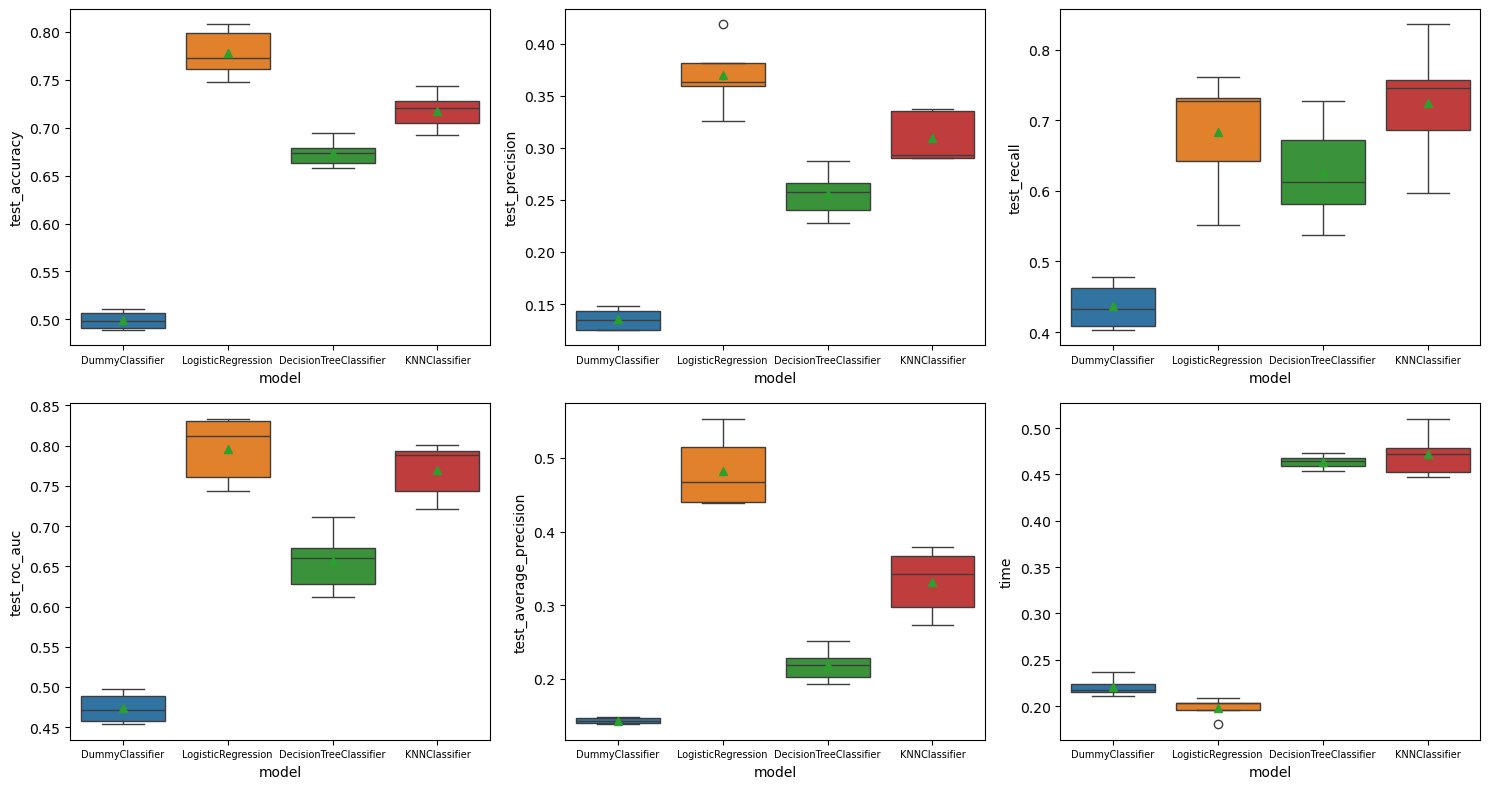

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(2, 3, figsize=(15, 8), tight_layout=True)

cols = df_results.columns[3:].tolist()

for ax, col in zip(axs.flatten(), cols):
    b = sns.boxplot(df_results, x="model", y=col, ax=ax, showmeans=True, palette="tab10", hue="model")
    b.set_xticklabels(b.get_xticklabels(), fontsize=7)

plt.show()

In [ ]:
'''
Na maioria dos scores, a regressão logística foi a que performou melhor
'''